In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/datasets/mbti_descriptions.csv')
df.head()

MBTI                                        Description
0  enfj  선도자 선도자(ENFJ)는 삶에서 위대한 사명을 위해 힘써야 한다는 느낌을 받곤 합...
1  enfj                                         선도자, 언변능숙형
2  enfj  온화하고 적극적이며 책임감이 강하다. 사교성이 풍부하고 동정심이 많다. 상당히 이타...
3  enfj  겉보기 특성 - 모임을 좋아하며 대화를 적극적으로 이끌어 나가는 면에서는 ENTJ와...
4  enfj  사회인격학의 쿼드라 그룹 모형으로는 Beta 그룹에 속한다. 해당 접근 방법에 의하...

In [2]:
import re
def preprocess_text(text):
    # HTML 태그 제거
    text = re.sub(r'<.*?>', '', text)
    # 대괄호 및 중괄호 내용 제거
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\{.*?\}', '', text)
    # 특수 문자 제거
    re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)
    # 연속된 공백 제거
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    return text.strip()
# 전처리 적용
df['Description'] = df['Description'].apply(preprocess_text)
# 전처리 후 데이터 확인
print(df.head())

   MBTI                                        Description
0  enfj  선도자 선도자(ENFJ)는 삶에서 위대한 사명을 위해 힘써야 한다는 느낌을 받곤 합...
1  enfj                                         선도자, 언변능숙형
2  enfj  온화하고 적극적이며 책임감이 강하다. 사교성이 풍부하고 동정심이 많다. 상당히 이타...
3  enfj  겉보기 특성 - 모임을 좋아하며 대화를 적극적으로 이끌어 나가는 면에서는 ENTJ와...
4  enfj  사회인격학의 쿼드라 그룹 모형으로는 Beta 그룹에 속한다. 해당 접근 방법에 의하...


In [4]:
import pandas as pd
from transformers import AutoTokenizer


#bert모델은 토큰의 length가 512가 넘어가지 않도록 해야함
#max_length로 정해둔 길이를 넘어가면 행추가
#512로 학습시 정확도가 많이 떨어지는점을 감안해서 숫자를 낮추면서 시도
def split_and_expand_descriptions(df, max_length=64):
    tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-generator')
    expanded_rows = []  # 확장된 행들을 저장할 리스트

    for _, row in df.iterrows():
        mbti = row['MBTI']
        text = row['Description']

        tokens = tokenizer.tokenize(text)
        # 토큰의 총 길이가 최대 길이 이하이면, 해당 행을 그대로 추가
        if len(tokens) <= max_length:
            expanded_rows.append({'MBTI': mbti, 'Description': text})
        else:
            # 최대 길이를 초과하면, 쪼개어 추가
            start = 0
            while start < len(tokens):
                split_tokens = tokens[start:start+max_length]
                split_text = tokenizer.convert_tokens_to_string(split_tokens)
                expanded_rows.append({'MBTI': mbti, 'Description': split_text})
                start += max_length

    # 새로운 데이터프레임 생성
    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df

# 함수 적용
expanded_df = split_and_expand_descriptions(df)

# expanded_df 확인
print(expanded_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/463 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (831 > 512). Running this sequence through the model will result in indexing errors


      MBTI                                        Description
0     enfj  선도자 선도자 ( ENFJ ) 는 삶에서 위대한 사명을 위해 힘써야 한다는 느낌을 ...
1     enfj  올바른 일을 할 기회를 마다하지 않습니다 선도자는 타고난 지도자라고 할 수 있으며 ...
2     enfj  영향을 주곤 합니다 또한 이들은 친구와 사랑하는 사람이 발전할 수 있도록 돕는 일에...
3     enfj  사람 선도자는 진실함과 이타주의 등 자신의 가치관을 적극적으로 설파하며, 부당하거나...
4     enfj  ##어내는 방법을 선택할 때가 많습니다 선도자는 다른 사람의 의도와 믿음을 간파하는...
...    ...                                                ...
1740  istp  평균 IQ(지능 지수)가 16개 유형 중 9위로 감각형(S) 중에서는 가장 높다. ...
1741  istp  xSxP 중에 수학 성적(학업 성취도)이 안 좋은 사람들은 '학습 목표를 장기와 단...
1742  istp  ISTP는 상황 파악 능력과 손재주가 좋지만 타인과 관계맺는 것을 어려워하는 편입니...
1743  istp  싶으면 최선을 다하는 편입니다. ISTP는 혼자 시간을 보낼 자유를 중요시하며, 취...
1744  istp  ISTP는 애정 표현을 잘 못해서 무뚝뚝해 보일 수 있지만, 사실은 속이 깊고 마음...

[1745 rows x 2 columns]


In [6]:
!pip install konlpy wordcloud

In [7]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HugginFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#	 http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
#
# 한국어 WordPiece 단위 BERT를 위한 Tokenization Class
# 수정: joonho.lim
# 일자: 2019-05-23
#
"""Tokenization classes."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import unicodedata
import os
import logging

logger = logging.getLogger(__name__)

PRETRAINED_VOCAB_ARCHIVE_MAP = {
	'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt",
	'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt",
	'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt",
	'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt",
	'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt",
	'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt",
	'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt",
}
PRETRAINED_VOCAB_POSITIONAL_EMBEDDINGS_SIZE_MAP = {
	'bert-base-uncased': 512,
	'bert-large-uncased': 512,
	'bert-base-cased': 512,
	'bert-large-cased': 512,
	'bert-base-multilingual-uncased': 512,
	'bert-base-multilingual-cased': 512,
	'bert-base-chinese': 512,
}
VOCAB_NAME = 'vocab.txt'


def load_vocab(vocab_file):
	"""Loads a vocabulary file into a dictionary."""
	vocab = collections.OrderedDict()
	index = 0
	with open(vocab_file, "r", encoding="utf-8") as reader:
		while True:
			token = reader.readline()
			if not token:
				break

			### joonho.lim @ 2019-03-15
			if token.find('n_iters=') == 0 or token.find('max_length=') == 0 :
				continue
			token = token.split('\t')[0]

			token = token.strip()
			vocab[token] = index
			index += 1
	return vocab


def whitespace_tokenize(text):
	"""Runs basic whitespace cleaning and splitting on a peice of text."""
	text = text.strip()
	if not text:
		return []
	tokens = text.split()
	return tokens


class BertTokenizer(object):
	"""Runs end-to-end tokenization: punctuation splitting + wordpiece"""

	def __init__(self, vocab_file, do_lower_case=True, max_len=None,
				 never_split=("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]")):
		if not os.path.isfile(vocab_file):
			raise ValueError(
				"Can't find a vocabulary file at path '{}'. To load the vocabulary from a Google pretrained "
				"model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`".format(vocab_file))
		self.vocab = load_vocab(vocab_file)
		self.ids_to_tokens = collections.OrderedDict(
			[(ids, tok) for tok, ids in self.vocab.items()])
		self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case,
											  never_split=never_split)
		self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)
		self.max_len = max_len if max_len is not None else int(1e12)

	def tokenize(self, text):
		split_tokens = []
		for token in self.basic_tokenizer.tokenize(text):
			### joonho.lim @ 2019-03-15
			token += '_'
			for sub_token in self.wordpiece_tokenizer.tokenize(token):
				split_tokens.append(sub_token)
		return split_tokens

	def convert_tokens_to_ids(self, tokens):
		"""Converts a sequence of tokens into ids using the vocab."""
		ids = []
		for token in tokens:
			ids.append(self.vocab[token])
		if len(ids) > self.max_len:
			raise ValueError(
				"Token indices sequence length is longer than the specified maximum "
				" sequence length for this BERT model ({} > {}). Running this"
				" sequence through BERT will result in indexing errors".format(len(ids), self.max_len)
			)
		return ids

	def convert_ids_to_tokens(self, ids):
		"""Converts a sequence of ids in wordpiece tokens using the vocab."""
		tokens = []
		for i in ids:
			tokens.append(self.ids_to_tokens[i])
		return tokens


class BasicTokenizer(object):
	"""Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

	def __init__(self,
				 do_lower_case=True,
				 never_split=("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]")):
		"""Constructs a BasicTokenizer.

		Args:
		  do_lower_case: Whether to lower case the input.
		"""
		self.do_lower_case = do_lower_case
		self.never_split = never_split

	def tokenize(self, text):
		"""Tokenizes a piece of text."""
		text = self._clean_text(text)
		### joonho.lim @ 2019-03-15
		# # # This was added on November 1st, 2018 for the multilingual and Chinese
		# # # models. This is also applied to the English models now, but it doesn't
		# # # matter since the English models were not trained on any Chinese data
		# # # and generally don't have any Chinese data in them (there are Chinese
		# # # characters in the vocabulary because Wikipedia does have some Chinese
		# # # words in the English Wikipedia.).
		# # text = self._tokenize_chinese_chars(text)
		orig_tokens = whitespace_tokenize(text)
		split_tokens = []
		for token in orig_tokens:
			if self.do_lower_case and token not in self.never_split:
				token = token.lower()
				token = self._run_strip_accents(token)
			split_tokens.extend(self._run_split_on_punc(token))

		output_tokens = whitespace_tokenize(" ".join(split_tokens))
		return output_tokens

	def _run_strip_accents(self, text):
		"""Strips accents from a piece of text."""
		text = unicodedata.normalize("NFD", text)
		output = []
		for char in text:
			cat = unicodedata.category(char)
			if cat == "Mn":
				continue
			output.append(char)
		return "".join(output)

	def _run_split_on_punc(self, text):
		"""Splits punctuation on a piece of text."""
		if text in self.never_split:
			return [text]
		chars = list(text)
		i = 0
		start_new_word = True
		output = []
		while i < len(chars):
			char = chars[i]
			if _is_punctuation(char):
				output.append([char])
				start_new_word = True
			else:
				if start_new_word:
					output.append([])
				start_new_word = False
				output[-1].append(char)
			i += 1

		return ["".join(x) for x in output]

	def _tokenize_chinese_chars(self, text):
		"""Adds whitespace around any CJK character."""
		output = []
		for char in text:
			cp = ord(char)
			if self._is_chinese_char(cp):
				output.append(" ")
				output.append(char)
				output.append(" ")
			else:
				output.append(char)
		return "".join(output)

	def _is_chinese_char(self, cp):
		"""Checks whether CP is the codepoint of a CJK character."""
		# This defines a "chinese character" as anything in the CJK Unicode block:
		#   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
		#
		# Note that the CJK Unicode block is NOT all Japanese and Korean characters,
		# despite its name. The modern Korean Hangul alphabet is a different block,
		# as is Japanese Hiragana and Katakana. Those alphabets are used to write
		# space-separated words, so they are not treated specially and handled
		# like the all of the other languages.
		if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
				(cp >= 0x3400 and cp <= 0x4DBF) or  #
				(cp >= 0x20000 and cp <= 0x2A6DF) or  #
				(cp >= 0x2A700 and cp <= 0x2B73F) or  #
				(cp >= 0x2B740 and cp <= 0x2B81F) or  #
				(cp >= 0x2B820 and cp <= 0x2CEAF) or
				(cp >= 0xF900 and cp <= 0xFAFF) or  #
				(cp >= 0x2F800 and cp <= 0x2FA1F)):  #
			return True

		return False

	def _clean_text(self, text):
		"""Performs invalid character removal and whitespace cleanup on text."""
		output = []
		for char in text:
			cp = ord(char)
			if cp == 0 or cp == 0xfffd or _is_control(char):
				continue
			if _is_whitespace(char):
				output.append(" ")
			else:
				output.append(char)
		return "".join(output)


class WordpieceTokenizer(object):
	"""Runs WordPiece tokenization."""

	def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=100):
		self.vocab = vocab
		self.unk_token = unk_token
		self.max_input_chars_per_word = max_input_chars_per_word

	def tokenize(self, text):
		"""Tokenizes a piece of text into its word pieces.

		This uses a greedy longest-match-first algorithm to perform tokenization
		using the given vocabulary.

		For example:
		  input = "unaffable"
		  output = ["un", "##aff", "##able"]

		Args:
		  text: A single token or whitespace separated tokens. This should have
			already been passed through `BasicTokenizer`.

		Returns:
		  A list of wordpiece tokens.
		"""

		output_tokens = []
		for token in whitespace_tokenize(text):
			chars = list(token)
			if len(chars) > self.max_input_chars_per_word:
				output_tokens.append(self.unk_token)
				continue

			is_bad = False
			start = 0
			sub_tokens = []
			while start < len(chars):
				end = len(chars)
				cur_substr = None
				while start < end:
					substr = "".join(chars[start:end])
					### joonho.lim @ 2019-03-15
					# if start > 0:
						# substr = "##" + substr
					# print ( '[substr]\t%s\t%s\t%d\t%d' % ( substr, substr in self.vocab, start, end))
					if substr in self.vocab:
						cur_substr = substr
						break
					end -= 1
				if cur_substr is None:
					is_bad = True
					break
				sub_tokens.append(cur_substr)
				start = end

			if is_bad:
				output_tokens.append(self.unk_token)
			else:
				output_tokens.extend(sub_tokens)
		return output_tokens


def _is_whitespace(char):
	"""Checks whether `chars` is a whitespace character."""
	# \t, \n, and \r are technically contorl characters but we treat them
	# as whitespace since they are generally considered as such.
	if char == " " or char == "\t" or char == "\n" or char == "\r":
		return True
	cat = unicodedata.category(char)
	if cat == "Zs":
		return True
	return False


def _is_control(char):
	"""Checks whether `chars` is a control character."""
	# These are technically control characters but we count them as whitespace
	# characters.
	if char == "\t" or char == "\n" or char == "\r":
		return False
	cat = unicodedata.category(char)
	if cat.startswith("C"):
		return True
	return False


def _is_punctuation(char):
	### joonho.lim @ 2019-03-15
	return char == ' '

	# """Checks whether `chars` is a punctuation character."""
	# cp = ord(char)
	# # We treat all non-letter/number ASCII as punctuation.
	# # Characters such as "^", "$", and "`" are not in the Unicode
	# # Punctuation class but we treat them as punctuation anyways, for
	# # consistency.
	# if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
			# (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
		# return True
	# cat = unicodedata.category(char)
	# if cat.startswith("P"):
		# return True
	# return False


In [8]:
import transformers
import re
import random
import numpy as np


class BERT_Augmentation():
    def __init__(self):
        self.model_name = 'monologg/koelectra-base-v3-generator'
        self.model = transformers.AutoModelForMaskedLM.from_pretrained(self.model_name)
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_name)
        self.unmasker = transformers.pipeline("fill-mask", model=self.model, tokenizer=self.tokenizer)
        random.seed(42)
    def random_masking_replacement(self, sentence, ratio=0.15):
        """Masking random eojeol of the sentence, and recover them using PLM.

        Args:
            sentence (str): Source sentence
            ratio (int): Ratio of masking

        Returns:
          str: Recovered sentence
        """

        span = int(round(len(sentence.split()) * ratio))

        # 품질 유지를 위해, 문장의 어절 수가 4 이하라면 원문장을 그대로 리턴합니다.
        if len(sentence.split()) <= 4:
            return sentence

        mask = self.tokenizer.mask_token
        unmasker = self.unmasker

        unmask_sentence = sentence
        # 처음과 끝 부분을 [MASK]로 치환 후 추론할 때의 품질이 좋지 않음.
        random_idx = random.randint(1, len(unmask_sentence.split()) - span)

        unmask_sentence = unmask_sentence.split()
        # del unmask_sentence[random_idx:random_idx+span]
        cache = []
        for _ in range(span):
            # 처음과 끝 부분을 [MASK]로 치환 후 추론할 때의 품질이 좋지 않음.
            while cache and random_idx in cache:
                random_idx = random.randint(1, len(unmask_sentence) - 2)
            cache.append(random_idx)
            unmask_sentence[random_idx] = mask
            unmask_sentence = unmasker(" ".join(unmask_sentence))[0]['sequence']
            unmask_sentence = unmask_sentence.split()
        unmask_sentence = " ".join(unmask_sentence)
        unmask_sentence = unmask_sentence.replace("  ", " ")

        return unmask_sentence.strip()

    def random_masking_insertion(self, sentence, ratio=0.15):

        span = int(round(len(sentence.split()) * ratio))
        mask = self.tokenizer.mask_token
        unmasker = self.unmasker

        # Recover
        unmask_sentence = sentence

        for _ in range(span):
            unmask_sentence = unmask_sentence.split()
            random_idx = random.randint(0, len(unmask_sentence)-1)
            unmask_sentence.insert(random_idx, mask)
            unmask_sentence = unmasker(" ".join(unmask_sentence))[0]['sequence']

        unmask_sentence = unmask_sentence.replace("  ", " ")

        return unmask_sentence.strip()

In [9]:
augmenter=BERT_Augmentation()

model.safetensors:   0%|          | 0.00/149M [00:00<?, ?B/s]

In [10]:
import pandas as pd

def augment_and_split_long_texts(df, augmenter, method='replacement', ratio=0.15, max_length=128):
    augmented_rows = []  # 증강된 행들을 저장할 리스트

    for _, row in df.iterrows():
        original_mbti = row['MBTI']
        original_description = row['Description']

        # 증강 방법에 따라 Description 증강
        if method == 'replacement':
            try:
                augmented_description = augmenter.random_masking_replacement(original_description, ratio)
            except RuntimeError as e:
                print(f"Skipping long text due to error: {e}")
                continue
        elif method == 'insertion':
            try:
                augmented_description = augmenter.random_masking_insertion(original_description, ratio)
            except RuntimeError as e:
                print(f"Skipping long text due to error: {e}")
                continue

        # 증강된 텍스트를 토큰화하여 최대 길이에 맞게 분할
        tokens = augmenter.tokenizer.tokenize(augmented_description)
        if len(tokens) > max_length:
            start = 0
            while start < len(tokens):
                split_tokens = tokens[start:start + max_length]
                split_text = augmenter.tokenizer.convert_tokens_to_string(split_tokens)
                augmented_rows.append({'MBTI': original_mbti, 'Description': split_text})
                start += max_length
        else:
            augmented_rows.append({'MBTI': original_mbti, 'Description': augmented_description})

    # 원본 데이터프레임에 증강된 행들 추가
    augmented_df = pd.concat([df, pd.DataFrame(augmented_rows)], ignore_index=True)

    return augmented_df

# 예제 사용
# augmented_final_df = augment_and_split_long_texts(expanded_df, augmenter, method='replacement', ratio=0.15)
# print(augmented_final_df)


# 함수 적용
augmented_final_df = augment_and_split_long_texts(expanded_df, augmenter, method='replacement', ratio=0.15)

# 결과 확인
print(augmented_final_df)

      MBTI                                        Description
0     enfj  선도자 선도자 ( ENFJ ) 는 삶에서 위대한 사명을 위해 힘써야 한다는 느낌을 ...
1     enfj  올바른 일을 할 기회를 마다하지 않습니다 선도자는 타고난 지도자라고 할 수 있으며 ...
2     enfj  영향을 주곤 합니다 또한 이들은 친구와 사랑하는 사람이 발전할 수 있도록 돕는 일에...
3     enfj  사람 선도자는 진실함과 이타주의 등 자신의 가치관을 적극적으로 설파하며, 부당하거나...
4     enfj  ##어내는 방법을 선택할 때가 많습니다 선도자는 다른 사람의 의도와 믿음을 간파하는...
...    ...                                                ...
3485  istp  평균 IQ ( 지능 지수 ) 는 16개 유형 중 9위로 감각형 ( S ) 중에서는 ...
3486  istp  xSxP 중에 수학 성적 ( 학업 성적 ) 이 안 좋은 사람들은'학습 목표를 매월 ...
3487  istp  ISTP는 상황관리 능력과 손재주가 떨어져 타인과 관계맺는 걸 어려워하는 편입니다....
3488  istp  싶으면 최선을 다하는 편입니다. ISTP는 혼자 시간을 통한 자유를 중요시하며, 취...
3489  istp  ISTP는 애정 표현을 잘 못해서 무뚝뚝해 보일 수 있지만, 특히 속이 깊고 속이 ...

[3490 rows x 2 columns]


In [11]:
# 토크나이저 초기화
vocab_file = "/content/drive/MyDrive/korBert/vocab.korean.rawtext.list"
# BertTokenizer 직접 초기화
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=False)

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence

def prepare_data(df, max_len=512):
    sentences = df['Description'].values
    labels = df['MBTI'].values

    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 각 시퀀스를 max_len으로 자릅니다.
    input_ids = [tokenizer.convert_tokens_to_ids(x)[:max_len] for x in tokenized_texts]

    # 패딩 적용
    padded_input_ids = []
    attention_masks = []
    for seq in input_ids:
        padding_length = max_len - len(seq)
        padded_seq = seq + ([0] * padding_length)  # 0으로 패딩
        attention_mask = [1 if i > 0 else 0 for i in padded_seq]  # 어텐션 마스크 업데이트
        padded_input_ids.append(padded_seq)
        attention_masks.append(attention_mask)

    return torch.tensor(padded_input_ids), labels, torch.tensor(attention_masks),tokenized_texts

input_ids, labels, attention_masks, tokenized_texts = prepare_data(augmented_final_df.copy())
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# PyTorch 텐서로 변환 (이미 텐서로 변환되었으므로 이 단계는 생략 가능)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


# 레이블 인코딩
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_validation_labels = label_encoder.transform(validation_labels)
train_labels = torch.tensor(encoded_train_labels)
validation_labels = torch.tensor(encoded_validation_labels)

# 데이터 로더 설정
batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

<ipython-input-24-1fec6b0aca43>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-24-1fec6b0aca43>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)
<ipython-input-24-1fec6b0aca43>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
<ipython-input-24-1fec6b0aca43>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

In [37]:
augmented_final_df['tokenized_texts'] = tokenized_texts

In [50]:
augmented_final_df.head()

MBTI                                        Description  \
0  enfj  선도자 선도자 ( ENFJ ) 는 삶에서 위대한 사명을 위해 힘써야 한다는 느낌을 ...   
1  enfj  올바른 일을 할 기회를 마다하지 않습니다 선도자는 타고난 지도자라고 할 수 있으며 ...   
2  enfj  영향을 주곤 합니다 또한 이들은 친구와 사랑하는 사람이 발전할 수 있도록 돕는 일에...   
3  enfj  사람 선도자는 진실함과 이타주의 등 자신의 가치관을 적극적으로 설파하며, 부당하거나...   
4  enfj  ##어내는 방법을 선택할 때가 많습니다 선도자는 다른 사람의 의도와 믿음을 간파하는...   

                                           tokenized  \
0  [[선], [도], [자], [선], [도], [자], [], [], [], [],...   
1  [[], [바], [른], [일], [], [기회], [마], [], [], [],...   
2  [[영향], [주], [곤], [], [또한], [이], [친구], [], [사랑]...   
3  [[사람], [선], [도], [], [진], [실], [함], [과], [이], ...   
4  [[], [], [], [], [방법], [선택], [], [때], [], [], ...   

                                     tokenized_texts  
0  [선, 도, 자_, 선, 도, 자_, (, _, E, N, F, J, _, )_, ...  
1  [올, 바, 른_, 일을_, 할_, 기회를_, 마, 다, 하지_, 않, 습니다_, ...  
2  [영향을_, 주, 곤_, 합니다_, 또한_, 이들은_, 친구, 와_, 사랑, 하는_...  
3  [사람_, 선, 도, 자는_, 진, 실, 함, 과_, 이, 타, 주의_, 등_, 자...  
4  [#, #, 어, 내는_, 방법을_, 선택, 할_, 때, 가_, 많, 습니다_, 선...

In [54]:
# tokenized_texts를 만들기 위한 함수 정의
def tokenize_korean_text(text):
    tokens = okt.nouns(text)
    return tokens

In [80]:
from collections import Counter

# 각 MBTI 유형에 대해 특히 빈도가 높은 단어를 추출하는 함수
def get_top_words_by_type_without_overlap(tokenized_texts, labels, mbti_types, top_n=100):
    top_words_by_type = {}
    all_text_by_type = {}

    # 각 MBTI 유형별로 모든 텍스트를 하나의 리스트로 결합
    for mbti_type in mbti_types:
        indices = [i for i, label in enumerate(labels) if label == mbti_type]
        texts = [tokenized_texts[i] for i in indices]
        all_text_by_type[mbti_type] = [word for text in texts for word in text]

    # 모든 텍스트를 하나의 리스트로 결합
    all_text = [word for mbti_type, text in all_text_by_type.items() for word in text]

    # 각 단어가 각 MBTI 유형에서 등장하는 횟수를 계산
    word_count_by_type = {word: Counter(text) for word, text in all_text_by_type.items()}

    # 각 MBTI 유형에 특히 빈도가 높은 단어 추출
    for mbti_type in mbti_types:
        top_words = []
        for word, count in word_count_by_type[mbti_type].most_common(top_n):
            # 다른 MBTI 유형에 등장하지 않는 단어만 추가
            if all_text.count(word) == count:
                top_words.append(word)
        top_words_by_type[mbti_type] = top_words

    return top_words_by_type

# 각 MBTI 유형에 대해 특히 빈도가 높은 단어 리스트 추출
mbti_types = augmented_final_df['MBTI'].unique()
top_words_by_type = get_top_words_by_type_without_overlap(augmented_final_df['Description'].apply(tokenize_korean_text), labels, mbti_types)

# 각 MBTI 유형별로 파일로 저장
for mbti_type, top_words in top_words_by_type.items():
    with open(f'/{mbti_type}_top_words_without_overlap.txt', 'w', encoding='utf-8') as f:
        for word in top_words:
            f.write(f'{word}\n')


In [58]:
from collections import Counter

# 각 MBTI 유형에 대해 가장 빈도가 높은 단어를 찾는 함수
def get_top_words_by_type(tokenized_texts, labels, mbti_types, top_n=200):
    top_words_by_type = {}
    for mbti_type in mbti_types:
        # 해당 유형에 속하는 텍스트들의 인덱스 추출
        indices = [i for i, label in enumerate(labels) if label == mbti_type]
        # 해당 유형에 속하는 텍스트들의 토큰화된 데이터 추출
        texts = [tokenized_texts[i] for i in indices]
        # 모든 텍스트들을 하나의 리스트로 펼침
        all_tokens = [token for text in texts for token in text]
        # 단어 빈도 계산
        word_freq = Counter(all_tokens)
        # 가장 빈도가 높은 단어들 선택
        top_words = [word for word, freq in word_freq.most_common(top_n)]
        top_words_by_type[mbti_type] = top_words
    return top_words_by_type

# 각 MBTI 유형에 대해 가장 빈도가 높은 단어 리스트 추출
mbti_types = augmented_final_df['MBTI'].unique()
top_words_by_type = get_top_words_by_type(augmented_final_df['Description'].apply(tokenize_korean_text), labels, mbti_types)

# 각 MBTI 유형별로 파일로 저장
for mbti_type, top_words in top_words_by_type.items():
    with open(f'/content/drive/MyDrive/datasets/wordcloud/{mbti_type}_top_words.txt', 'w', encoding='utf-8') as f:
        for word in top_words:
            f.write(f'{word}\n')

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
okt = Okt()

In [ ]:
# tokenized_texts를 만들기 위한 함수 정의
def tokenize_korean_text(text):
    tokens = okt.nouns(text)
    return tokens

In [57]:
augmented_final_df['Description']

0       선도자 선도자 ( ENFJ ) 는 삶에서 위대한 사명을 위해 힘써야 한다는 느낌을 ...
1       올바른 일을 할 기회를 마다하지 않습니다 선도자는 타고난 지도자라고 할 수 있으며 ...
2       영향을 주곤 합니다 또한 이들은 친구와 사랑하는 사람이 발전할 수 있도록 돕는 일에...
3       사람 선도자는 진실함과 이타주의 등 자신의 가치관을 적극적으로 설파하며, 부당하거나...
4       ##어내는 방법을 선택할 때가 많습니다 선도자는 다른 사람의 의도와 믿음을 간파하는...
                              ...                        
3485    평균 IQ ( 지능 지수 ) 는 16개 유형 중 9위로 감각형 ( S ) 중에서는 ...
3486    xSxP 중에 수학 성적 ( 학업 성적 ) 이 안 좋은 사람들은'학습 목표를 매월 ...
3487    ISTP는 상황관리 능력과 손재주가 떨어져 타인과 관계맺는 걸 어려워하는 편입니다....
3488    싶으면 최선을 다하는 편입니다. ISTP는 혼자 시간을 통한 자유를 중요시하며, 취...
3489    ISTP는 애정 표현을 잘 못해서 무뚝뚝해 보일 수 있지만, 특히 속이 깊고 속이 ...
Name: Description, Length: 3490, dtype: object

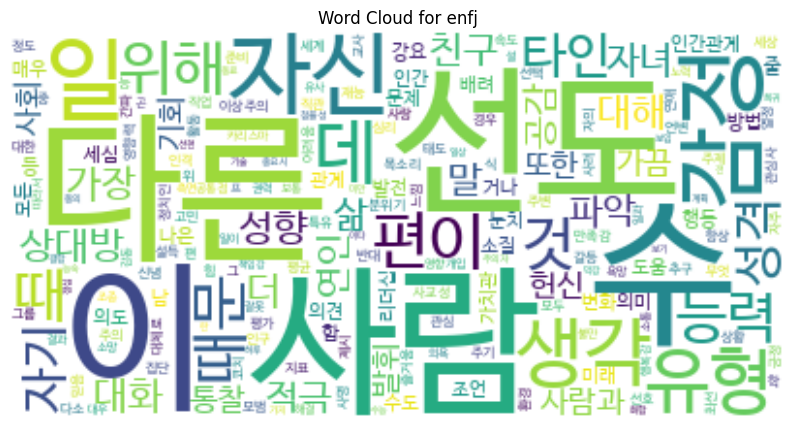

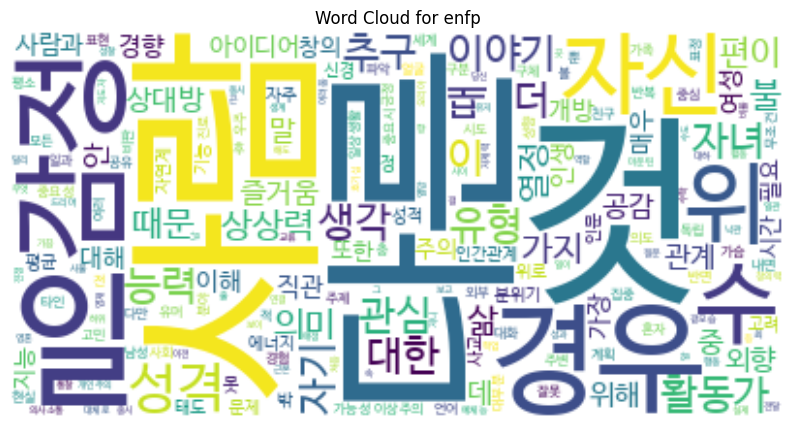

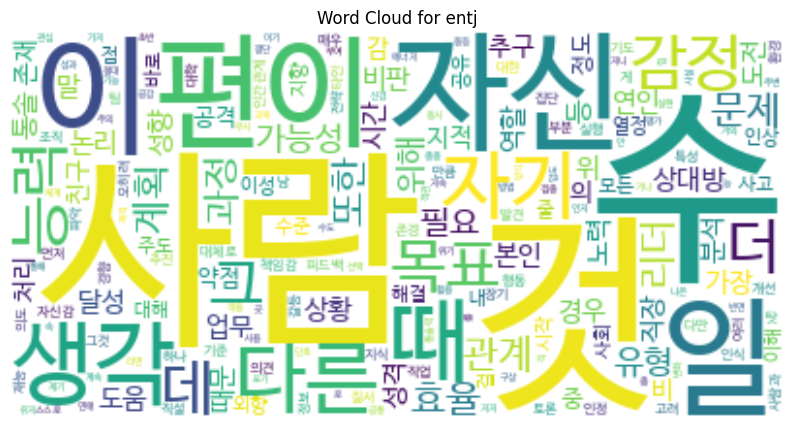

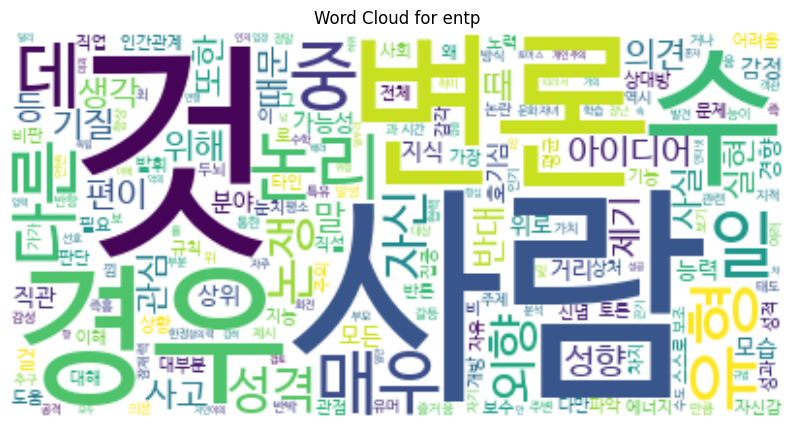

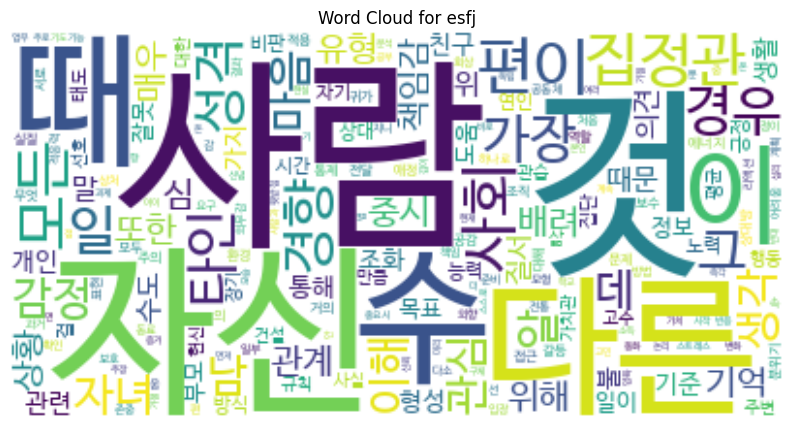

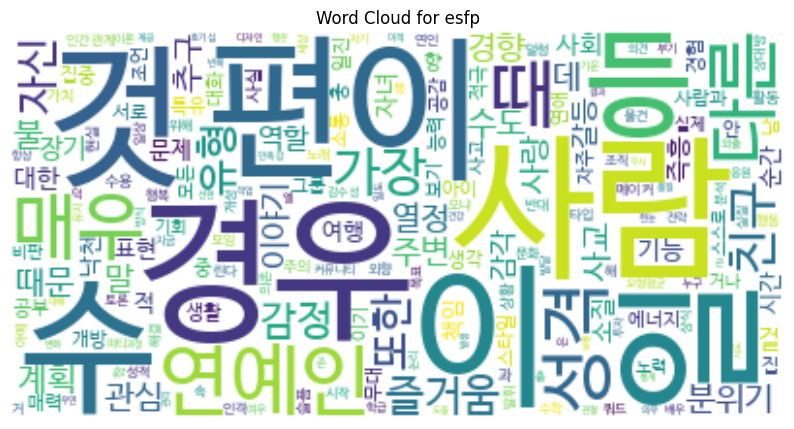

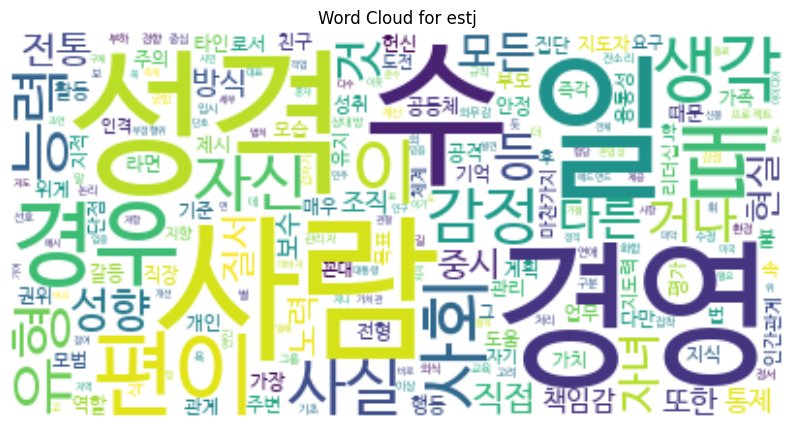

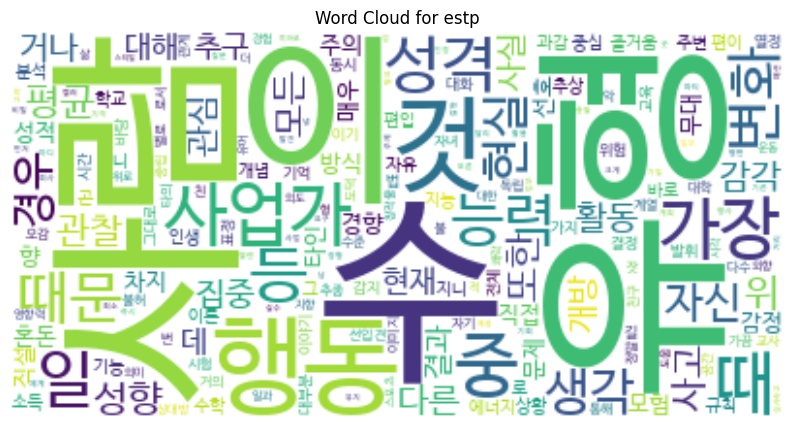

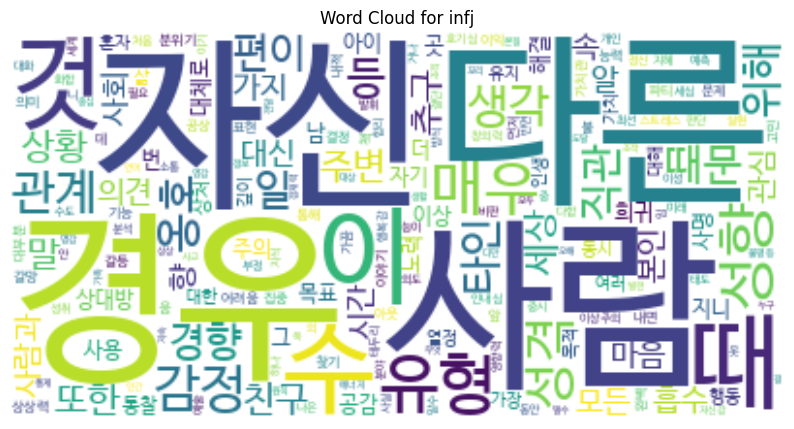

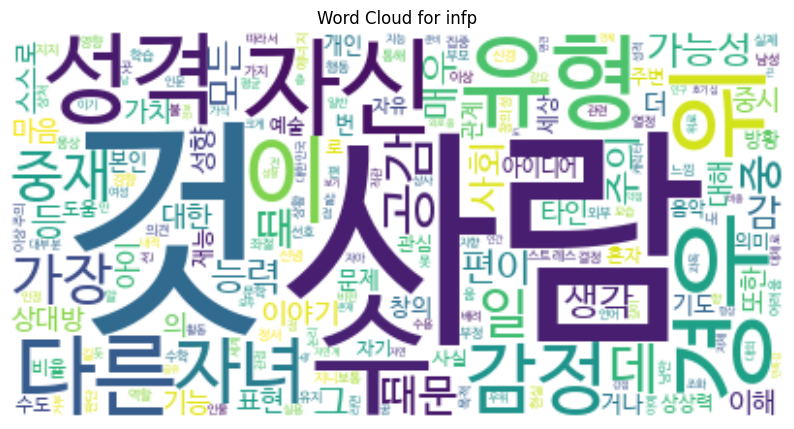

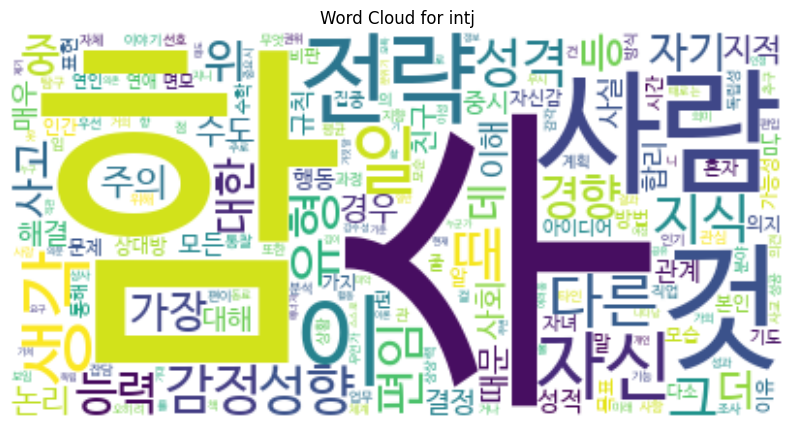

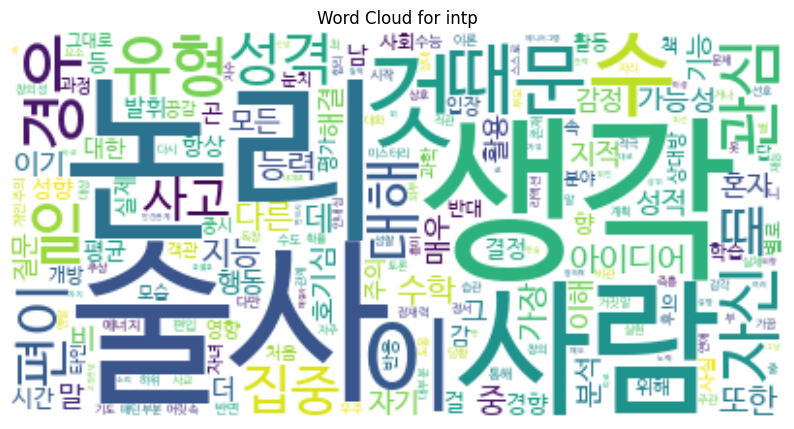

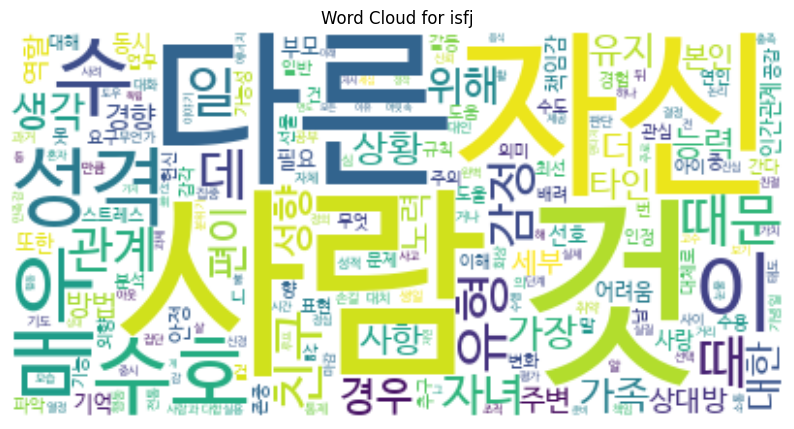

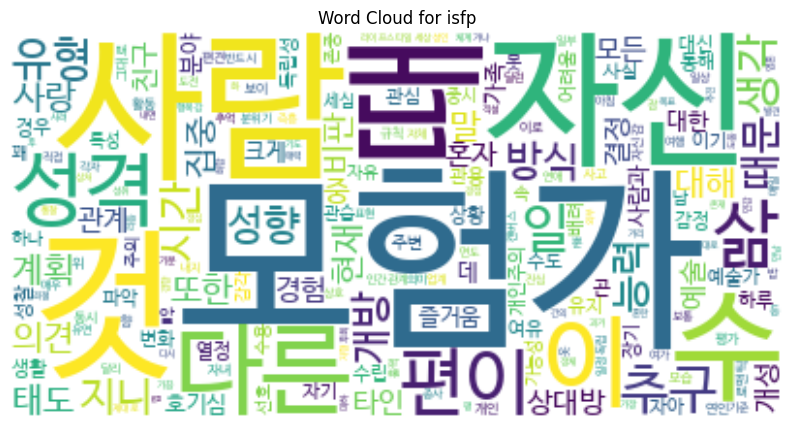

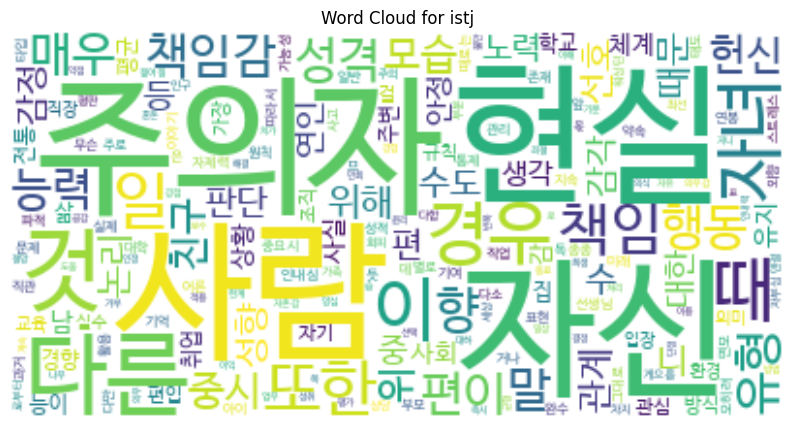

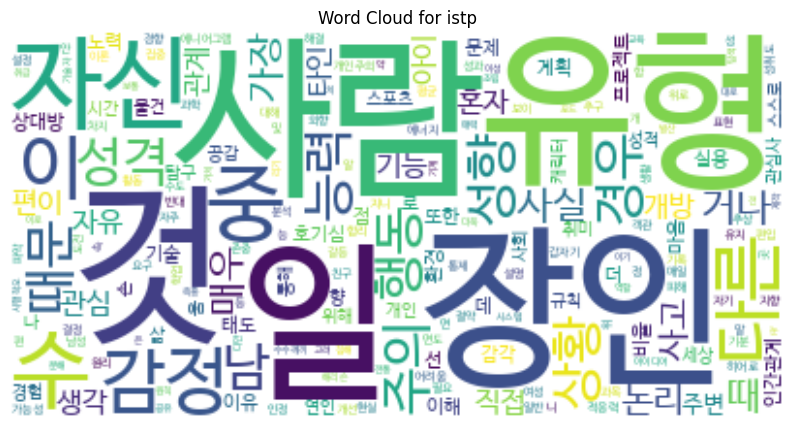

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
output_dir = '/content/drive/MyDrive/datasets/'
# 각 MBTI 유형별로 파일로 저장된 가장 빈도가 높은 단어 리스트를 읽어옵니다.
top_words_by_type = {}
for mbti_type in mbti_types:
    with open(f'{mbti_type}_top_words.txt', 'r', encoding='utf-8') as f:
        top_words_by_type[mbti_type] = [line.strip() for line in f]

# 각 MBTI 유형별로 가장 빈도가 높은 단어들을 결합하여 하나의 텍스트로 만듭니다.
text_by_type = {mbti_type: ' '.join(top_words) for mbti_type, top_words in top_words_by_type.items()}

# 워드클라우드 생성 및 이미지 파일로 저장
for mbti_type, text in text_by_type.items():
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', background_color='white').generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {mbti_type}')
    plt.axis('off')
    plt.savefig(f'{output_dir}/wordcloud_{mbti_type}.png')  # 이미지 파일로 저장
    plt.show()

In [63]:
augmented_final_df.head()

MBTI                                        Description  \
0  enfj  선도자 선도자 ( ENFJ ) 는 삶에서 위대한 사명을 위해 힘써야 한다는 느낌을 ...   
1  enfj  올바른 일을 할 기회를 마다하지 않습니다 선도자는 타고난 지도자라고 할 수 있으며 ...   
2  enfj  영향을 주곤 합니다 또한 이들은 친구와 사랑하는 사람이 발전할 수 있도록 돕는 일에...   
3  enfj  사람 선도자는 진실함과 이타주의 등 자신의 가치관을 적극적으로 설파하며, 부당하거나...   
4  enfj  ##어내는 방법을 선택할 때가 많습니다 선도자는 다른 사람의 의도와 믿음을 간파하는...   

                                           tokenized  \
0  [[선], [도], [자], [선], [도], [자], [], [], [], [],...   
1  [[], [바], [른], [일], [], [기회], [마], [], [], [],...   
2  [[영향], [주], [곤], [], [또한], [이], [친구], [], [사랑]...   
3  [[사람], [선], [도], [], [진], [실], [함], [과], [이], ...   
4  [[], [], [], [], [방법], [선택], [], [때], [], [], ...   

                                     tokenized_texts  
0  [선, 도, 자_, 선, 도, 자_, (, _, E, N, F, J, _, )_, ...  
1  [올, 바, 른_, 일을_, 할_, 기회를_, 마, 다, 하지_, 않, 습니다_, ...  
2  [영향을_, 주, 곤_, 합니다_, 또한_, 이들은_, 친구, 와_, 사랑, 하는_...  
3  [사람_, 선, 도, 자는_, 진, 실, 함, 과_, 이, 타, 주의_, 등_, 자...  
4  [#, #, 어, 내는_, 방법을_, 선택, 할_, 때, 가_, 많, 습니다_, 선...

In [64]:
#여기서부터 다시 시작
# 1번

from transformers import BertConfig, BertForSequenceClassification

# 모델 설정 및 사전 훈련된 가중치 로드
config = BertConfig.from_json_file('/content/drive/MyDrive/korBert/bert_config.json')
config.num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/korBert/pytorch_model.bin', config=config)


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/korBert/pytorch_model.bin and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
epochs=20

In [70]:
#2번
import os
import torch
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
# 옵티마이저 정의
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.05)
# 스케줄러 정의
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# 손실 함수
loss_fn = nn.CrossEntropyLoss()

#변수에 값 저장용
best_val_accuracy = 0.0
best_model_state = None
model_save_path = '/content/drive/MyDrive/datasets/best_model_state_02.bin'

In [67]:
import numpy as np
import time
import datetime
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 포맷 함수
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


In [68]:
# 3번
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30797, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [71]:
#4번
import csv
train_losses = []
validation_losses = []  # 검증 손실 기록을 위한 리스트 추가
validation_accuracies = []
results_file = "/content/drive/MyDrive/korBert/training_results_0303.csv"
# 결과 파일 초기화
with open(results_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Training Loss", "Validation Loss", "Validation Accuracy"])

In [72]:
#5번
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

# 학습 루프
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        logits=outputs.logits
        # 손실 계산
        loss = loss_fn(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # 검증
    print("Running Validation...")
    total_eval_loss = 0
    total_eval_accuracy = 0
    model.eval()

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            logits = outputs.logits
            # 손실 계산
            loss = loss_fn(logits, b_labels)
            total_eval_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    validation_losses.append(avg_val_loss)
    validation_accuracies.append(avg_val_accuracy)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Average validation loss: {0:.2f}".format(avg_val_loss))
    print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    scheduler.step(avg_val_loss)

    # 최고 검증 정확도 업데이트 및 모델 저장
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        torch.save(model.state_dict(), model_save_path)

       # 결과 파일에 기록
    with open(results_file, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch_i + 1, avg_train_loss, avg_val_loss, best_val_accuracy])

print("Training complete!")


======== Epoch 1 / 20 ========
Training...
Running Validation...
  Average training loss: 2.41
  Average validation loss: 2.32
  Validation Accuracy: 0.27
======== Epoch 2 / 20 ========
Training...
Running Validation...
  Average training loss: 1.84
  Average validation loss: 1.59
  Validation Accuracy: 0.53
======== Epoch 3 / 20 ========
Training...
Running Validation...
  Average training loss: 0.99
  Average validation loss: 1.18
  Validation Accuracy: 0.68
======== Epoch 4 / 20 ========
Training...
Running Validation...
  Average training loss: 0.47
  Average validation loss: 0.96
  Validation Accuracy: 0.75
======== Epoch 5 / 20 ========
Training...
Running Validation...
  Average training loss: 0.25
  Average validation loss: 0.92
  Validation Accuracy: 0.78
======== Epoch 6 / 20 ========
Training...
Running Validation...
  Average training loss: 0.18
  Average validation loss: 0.99
  Validation Accuracy: 0.78
======== Epoch 7 / 20 ========
Training...
Running Validation...
  Ave

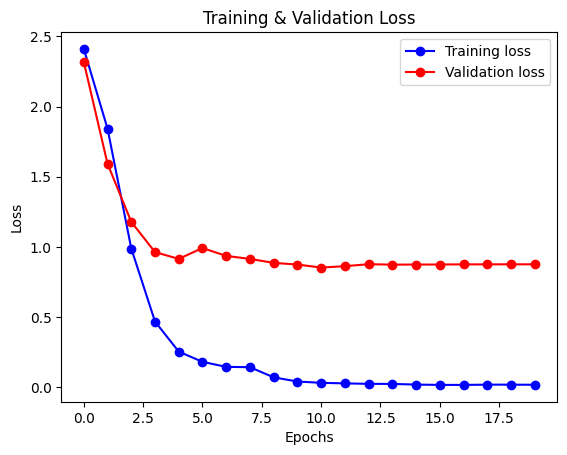

In [73]:
plt.plot(train_losses, 'b-o', label='Training loss')
plt.plot(validation_losses, 'r-o', label='Validation loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [74]:
import joblib
joblib.dump(label_encoder, '/content/drive/MyDrive/korBert/label_encoder_01.pkl')

['/content/drive/MyDrive/korBert/label_encoder_01.pkl']

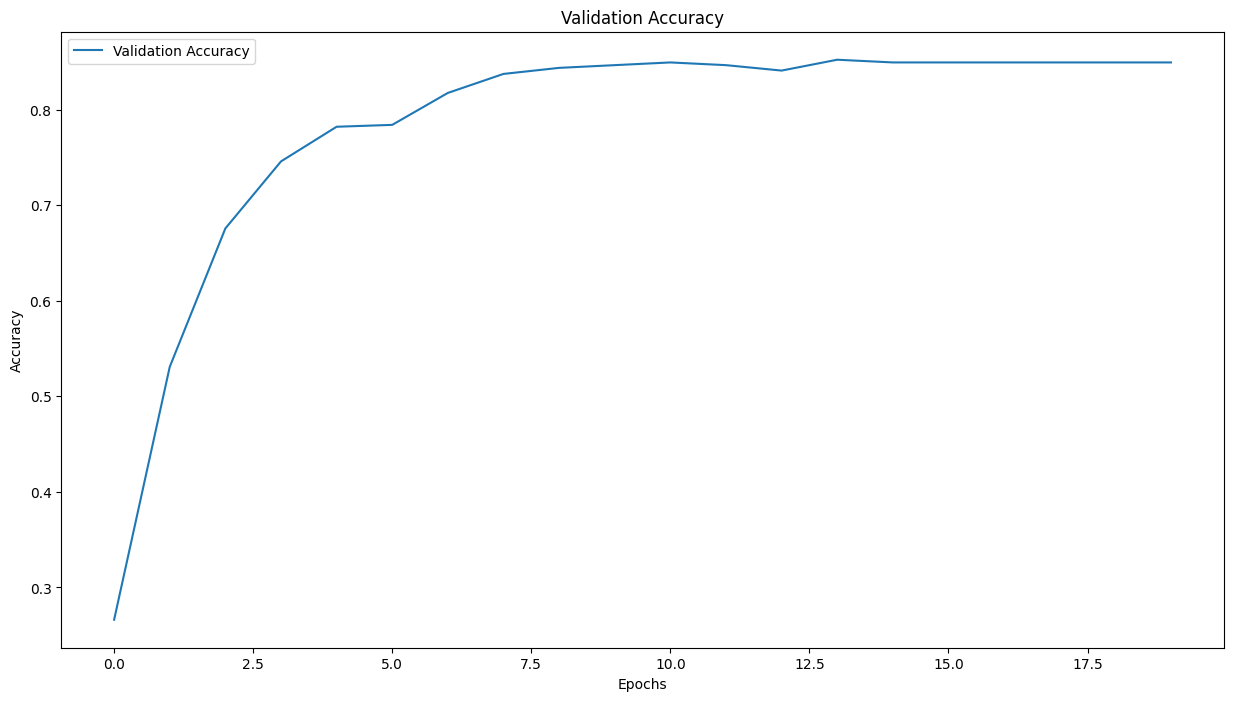

In [75]:
# 검증 정확도 그래프
plt.figure(figsize=(15, 8))
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [110]:
max_len=512
input_text='''
함
수
사람
것
전략
이
자신
생각
일
다른
때
감정
지식
유형
그
성향
성격
편임
경향
능력
'''
preprocess_input_text=preprocess_text(input_text)

def prepare_data_for_bert(input_text, tokenizer, max_len=512):
    # 텍스트 전처리(소문자 변환 등) 및 토큰화
    tokens = tokenizer.tokenize(input_text)

    # 토큰을 ID로 변환
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # 최대 길이로 패딩 및 어텐션 마스크 생성
    padding_length = max_len - len(token_ids)
    attention_mask = [1] * len(token_ids) + [0] * padding_length
    token_ids += [0] * padding_length  # 패딩 적용

    # 텐서로 변환
    input_ids = torch.tensor([token_ids])
    attention_masks = torch.tensor([attention_mask])

    return input_ids, attention_masks


input_ids, attention_masks = prepare_data_for_bert(preprocess_input_text,tokenizer)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/best_model_state_01.bin'))

<All keys matched successfully>

In [111]:
model.eval()
with torch.no_grad():
    outputs = model(input_ids.to(device), attention_mask=attention_masks.to(device))
    logits = outputs.logits
    # 로짓을 확률로 변환
    probabilities = torch.softmax(logits, dim=1).detach().cpu().numpy()

    # 가장 높은 확률을 가진 클래스의 인덱스를 추출
    predicted_label_idx = np.argmax(probabilities, axis=1)[0]

    predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]

print(f"Predicted label: {predicted_label} with probability {probabilities[0][predicted_label_idx]:.4f}")

Predicted label: intj with probability 0.9996
